# Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pulp
from pulp import *
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Part I

## Load Data

In [2]:
# Import Data 
df = pd.read_csv('player_sample.csv')
df['Price'] = df['Price'].fillna(0)
df.describe()

,Age,Previous App Purchases,Price
count,10000.000000,10000.000000,10000.000000
mean,36.588400,187.724300,1.811900
std,15.647053,81.677551,3.200069
min,11.000000,0.000000,0.000000
25%,27.000000,121.000000,0.000000
50%,32.000000,226.000000,0.000000
75%,39.000000,246.000000,2.500000
max,75.000000,312.000000,12.000000


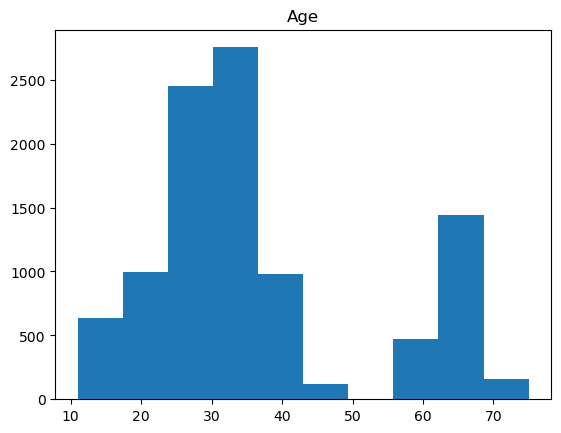

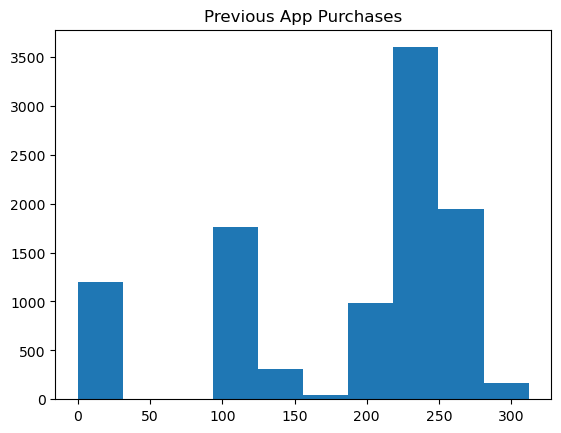

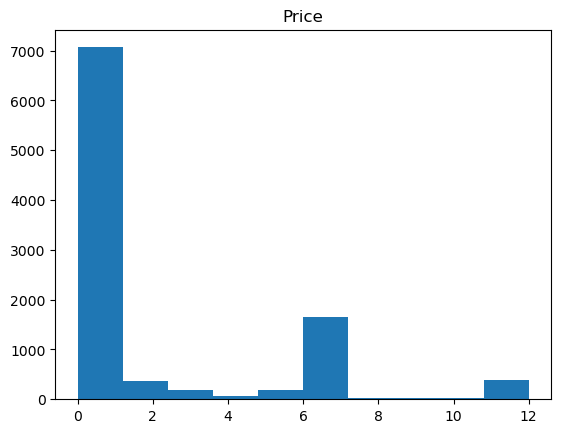

In [3]:
# Plot Distributions
for col in df.columns:
    plt.hist(df[col], bins=10)
    plt.title(col)
    plt.show()

## Question 1

In [4]:
# Get the count of each price
demand_df = pd.DataFrame(df['Price'].value_counts())
demand_df = demand_df.reset_index()
demand_df.columns = ['Price', 'Demand']

# Sort the prices, needed for next step
demand_df = demand_df.sort_values('Price', ascending = False)
demand_df = demand_df.reset_index()
demand_df = demand_df.drop('index', axis = 1)

# Display Table 
demand_df

,Price,Demand
0,12.0,368
1,11.0,11
2,10.0,21
3,9.0,30
4,8.0,34
5,7.0,479
6,6.0,1173
7,5.0,185
8,4.0,59
9,3.0,72


In [5]:
# Case Vars
num_people = 2000000
sample_size = 10000

# Calc probability and cumulative sum
demand_df['Probability'] = demand_df['Demand'] / sum(demand_df['Demand'])
demand_df['CumulativeSum'] = demand_df['Probability'].cumsum()

In [6]:
# Cumulative demand and its associated revenue 
demand_df['CumulativeDemand'] = num_people * demand_df['CumulativeSum']
demand_df['CumulativeRevenue'] = demand_df['Price'] * demand_df['CumulativeDemand']

In [7]:
demand_df

,Price,Demand,Probability,CumulativeSum,CumulativeDemand,CumulativeRevenue
0,12.0,368,0.0368,0.0368,73600.0,883200.0
1,11.0,11,0.0011,0.0379,75800.0,833800.0
2,10.0,21,0.0021,0.0400,80000.0,800000.0
3,9.0,30,0.0030,0.0430,86000.0,774000.0
4,8.0,34,0.0034,0.0464,92800.0,742400.0
5,7.0,479,0.0479,0.0943,188600.0,1320200.0
6,6.0,1173,0.1173,0.2116,423200.0,2539200.0
7,5.0,185,0.0185,0.2301,460200.0,2301000.0
8,4.0,59,0.0059,0.2360,472000.0,1888000.0
9,3.0,72,0.0072,0.2432,486400.0,1459200.0


In [8]:
# Find the optimal price
bestPrice_df = demand_df.loc[demand_df['CumulativeRevenue'] == demand_df['CumulativeRevenue'].max()]
bestPrice_df

,Price,Demand,Probability,CumulativeSum,CumulativeDemand,CumulativeRevenue
6,6.0,1173,0.1173,0.2116,423200.0,2539200.0


<AxesSubplot:title={'center':'Demand vs Revenue'}, xlabel='Price'>

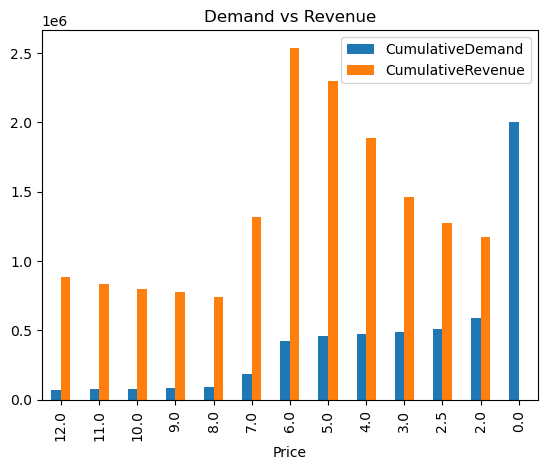

In [9]:
# Plot
demand_df.plot.bar(x = 'Price', y = ['CumulativeDemand', 'CumulativeRevenue'], title = 'Demand vs Revenue')

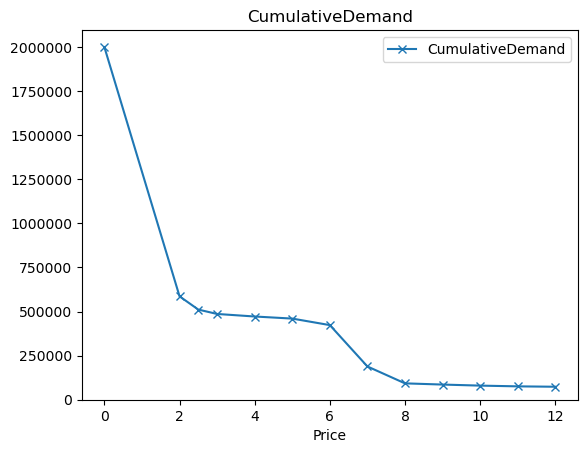

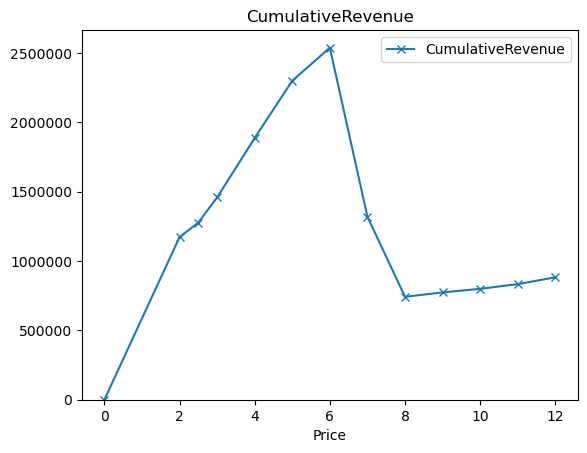

In [10]:
temp = ['CumulativeDemand', 'CumulativeRevenue']
for i in temp: 
    demand_df.plot(x = 'Price', y = i, kind = 'line', marker = 'x')
    plt.ylim(ymin = 0)
    plt.title(i)
    plt.ticklabel_format(style = 'plain', axis = 'y')
    plt.show()

## Question 2

Text(0, 0.5, 'In App Spending')

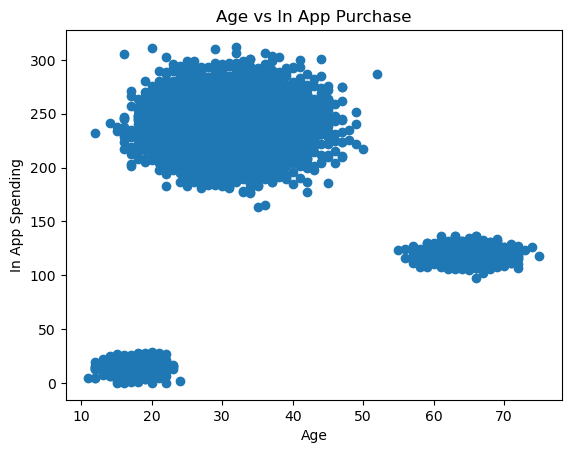

In [11]:
# Graph age vs in app spending
plt.scatter(x = df['Age'], y = df['Previous App Purchases'])
plt.title('Age vs In App Purchase')
plt.xlabel('Age')
plt.ylabel('In App Spending')

In [12]:
# Create new df
cluster_df = df.copy()
cluster_df.dropna(inplace = True)

# Create 3 clusters, confirmed visually
kmeans = KMeans(n_clusters = 3, random_state = 1)
kmeans.fit(cluster_df)

# Get labels and centroids
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Add labels to the df
cluster_df['Cluster'] = labels

Text(0, 0.5, 'In App Spending')

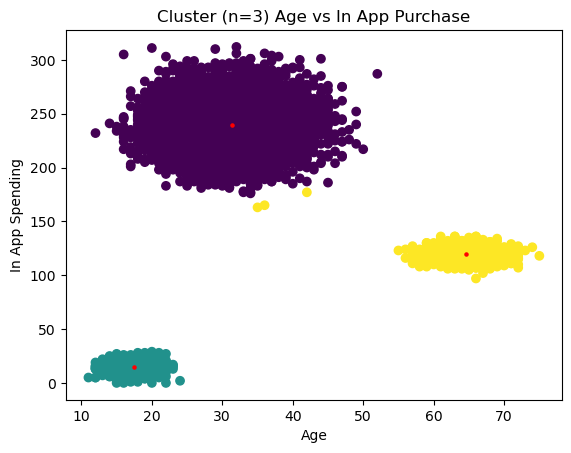

In [13]:
# Plot the clusters and the centroid (red)
plt.scatter(cluster_df['Age'], cluster_df['Previous App Purchases'], c = cluster_df['Cluster'])
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color = 'r', s = 5)

# Formatting graph
plt.title('Cluster (n=3) Age vs In App Purchase')
plt.xlabel('Age')
plt.ylabel('In App Spending')

In [14]:
# Define dict for storing results
cluster_revenues = {}

# Loop through the three clusters and find the max venue price for each
def cluster_revenue(cluster_df):
    revenue = 0
    for i in range(3):
        # Make temp df with matching cluster numbers
        temp_df = pd.DataFrame(cluster_df.loc[cluster_df['Cluster'] == i])
        
        # Get the count of each price
        temp_df = pd.DataFrame(temp_df['Price'].value_counts())
        temp_df = temp_df.reset_index()
        temp_df.columns = ['Price', 'Demand']

        # Sort the prices, needed for next step
        temp_df = temp_df.sort_values('Price', ascending = False)
        temp_df = temp_df.reset_index()
        temp_df = temp_df.drop('index', axis=1)

        # Calc probability and cumulative sum
        temp_df['Probability'] = temp_df['Demand'] / len(cluster_df.loc[cluster_df['Cluster'] == i])
        temp_df['CumulativeSum'] = temp_df['Probability'].cumsum()

        # Cumulative demand and its associated revenue 
        temp_df['CumulativeDemand'] =  temp_df['CumulativeSum'] * (len(cluster_df.loc[cluster_df['Cluster'] == i]) / sample_size) 
        temp_df['CumulativeRevenue'] = temp_df['Price'] * num_people * temp_df['CumulativeDemand']
        
        # Get highest revenue and add it to total
        highest_revenue = temp_df['CumulativeRevenue'].max()
        price = temp_df.loc[temp_df['CumulativeRevenue'] == highest_revenue]['Price'].values[0]
        revenue += highest_revenue
        
        # Print and add to dictionary
        print(f'Cluster: {i} has a revenue of ${highest_revenue} at Price: ${price}')
        
        cluster_revenues[i] = [price, highest_revenue]
        
    return revenue

# Call function and print results
revenue = cluster_revenue(cluster_df)
print(f'Sum of revenues: {revenue}')


Cluster: 0 has a revenue of $2011200.0 at Price: $6.0
Cluster: 1 has a revenue of $240000.0 at Price: $2.0
Cluster: 2 has a revenue of $883200.0 at Price: $12.0
Sum of revenues: 3134400.0


In [15]:
cluster_revenues

{0: [6.0, 2011200.0], 1: [2.0, 240000.0], 2: [12.0, 883200.0]}

# Part II

In [75]:
num_participant = num_people * 0.1
num_participant

200000.0

In [76]:
dfs = []
for _ in range(int(num_participant/sample_size)):
    dfs.append(df.copy())
customer_df = pd.concat(dfs, ignore_index=True)
del dfs
customer_df

,Age,Previous App Purchases,Price
0,37,218,6.0
1,34,247,6.0
2,19,15,4.0
3,32,235,7.0
4,19,15,2.5
...,...,...,...
199995,31,241,0.0
199996,25,265,0.0
199997,25,259,0.0
199998,68,115,0.0


In [77]:
customers = customer_df.index.to_list()

## Model with a preset base price

In [78]:
base_rate = 6
M = 99999999

In [79]:
discounts = []
i = 0

while i <= 1:
    discounts.append(i)
    i += 0.05
    
discounts

[0,
 0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.3,
 0.35,
 0.39999999999999997,
 0.44999999999999996,
 0.49999999999999994,
 0.5499999999999999,
 0.6,
 0.65,
 0.7000000000000001,
 0.7500000000000001,
 0.8000000000000002,
 0.8500000000000002,
 0.9000000000000002,
 0.9500000000000003]

In [80]:
days = [1, 2]

In [81]:
model = LpProblem(name = 'Test_Model', sense = LpMaximize)

zVar = LpVariable.dict('z', (customers, days), lowBound = 0.0, upBound=1.0, cat = LpContinuous)
yVar = LpVariable.dict('y', (customers, days), cat = "Integer")
pVar = LpVariable.dict('p', (customers), lowBound = 0.0, cat = LpContinuous)
wVar = LpVariable.dict('w', (customers, days), cat = LpBinary)
xVar = LpVariable.dict('x', (customers), cat = LpBinary)
aVar = LpVariable.dicts("a", range(len(discounts)), cat="Binary")
bVar = LpVariable.dict("b", (customers, days), cat="Binary")
cVar = LpVariable.dict('c', (customers, days), lowBound = 0, cat = "Integer")

In [82]:
obj = lpSum([base_rate*(1-zVar[(i,1)]-zVar[(i,2)]) if base_rate*(1-zVar[(i,1)]-zVar[(i,2)])<=customer_df.loc[i,'Price'] \
             else 0 for i in customers])
model += obj

In [ ]:
obj = lpSum([base_rate*(1-zVar[(i,1)])*bVar[(i,1)]
                        
                        -zVar[(i,2)]) if base_rate*(1-zVar[(i,1)]-zVar[(i,2)])<=customer_df.loc[i,'Price'] \
             else 0 for i in customers])
model += obj

In [83]:
# # Discount rates must be divisble by 5. Discount rates must be smaller than 100% and larger or equal to 0%.
# for i in customers:
#     for t in days:
#         model += zVar[(i,t)] >= 0
#         model += zVar[(i,t)] <= 1
#         model += zVar[(i,t)]*100 == yVar[(i,t)] * 5

In [84]:
# Discount rates must be divisble by 5. Discount rates must be smaller than 100% and larger or equal to 0%.
for i in customers:
    for t in days:
        model += zVar[(i,t)] == lpSum([aVar[i] * discounts[i] for i in range(len(discounts))])
        
model += pulp.lpSum(aVar.values()) == 1

In [85]:
# If a customer is offered a discount in day 1, he/she cannot be offered another discount in day 2
for i in customers:
    model += zVar[(i,1)] <= M * xVar[(i)]
    model += zVar[(i,2)] <= M * (1-xVar[(i)])

In [86]:
# # If the WTP is larger than the base_rate and the discount of the day is not 0, the counter for that day will increase by 1
# for i in customers:
#     model += pVar[i] - base_rate * (1 - zVar[(i,1)]) <= M * wVar[(i,1)]
#     model += pVar[i] - base_rate * (1 - zVar[(i,1)]) >= -M * (1 - wVar[(i,1)])
#     model += -zVar[(i,1)] <= M * wVar[(i,1)]
#     model += -zVar[(i,1)] <= -M * (1 - wVar[(i,1)])

In [87]:
# for i in customers:
#     model += pVar[i] - base_rate * (1 - zVar[(i,2)]) <= M * wVar[(i,2)]
#     model += pVar[i] - base_rate * (1 - zVar[(i,2)]) >= -M * (1 - wVar[(i,2)])
#     model += -zVar[(i,2)] <= M * wVar[(i,2)]
#     model += -zVar[(i,2)] <= -M * (1 - wVar[(i,2)])

In [88]:
# for i in customers:
#     model += pVar[i] - base_rate * (1 - zVar[(i,1)]) - M * (1 - bVar[(i,1)]) >= 0
#     model += pVar[i] - base_rate * (1 - zVar[(i,1)]) - M * bVar[(i,1)] <= -0.005
#     model += zVar[(i,1)] - M * (1 - cVar[(i,1)]) >= 0
#     model += zVar[(i,1)] - M * cVar[(i,1)] <= -0.005
#     model += bVar[(i,1)] + cVar[(i,1)] -1.5 - M * (1 - wVar[(i,1)]) >= 0
#     model += bVar[(i,1)] + cVar[(i,1)] -1.5 - M * wVar[(i,1)] <= -0.005

In [89]:
# If the WTP is larger than the base_rate and the discount of the day is not 0, the counter for that day will increase by 1
for i in customers:
    model += customer_df.loc[i,'Price'] - base_rate * (1 - zVar[(i,1)]) <= M * bVar[(i,1)]
    model += customer_df.loc[i,'Price'] - base_rate * (1 - zVar[(i,1)]) >= -M * (1 - bVar[(i,1)])+0.0005
    model += zVar[(i,1)] <= M * cVar[(i,1)]
    model += zVar[(i,1)] >= -M * (1 - cVar[(i,1)])+0.0005
    model += bVar[(i,1)] + cVar[(i,1)] -1.5  <= M * wVar[(i,1)]
    model += bVar[(i,1)] + cVar[(i,1)] -1.5  >= -M * (1 - wVar[(i,1)])+0.0005

In [90]:
for i in customers:
    model += customer_df.loc[i,'Price'] - base_rate * (1 - zVar[(i,2)]) <= M * bVar[(i,2)]
    model += customer_df.loc[i,'Price'] - base_rate * (1 - zVar[(i,2)]) >= -M * (1 - bVar[(i,2)])+0.0005
    model += zVar[(i,2)] <= M * cVar[(i,2)]
    model += zVar[(i,2)] >= -M * (1 - cVar[(i,2)])+0.0005
    model += bVar[(i,2)] + cVar[(i,2)] -1.5  <= M * wVar[(i,2)]
    model += bVar[(i,2)] + cVar[(i,2)] -1.5  >= -M * (1 - wVar[(i,2)])+0.0005

In [91]:
model += lpSum([wVar[(i,1)] for i in customers]) <= 10000
model += lpSum([wVar[(i,2)] for i in customers]) <= 10000

In [92]:
model.solve()
print("Status:", LpStatus[model.status])

Status: Optimal


In [93]:
total_rev = pulp.value(model.objective)
print("Total Revenue: " , total_rev)

Total Revenue:  1200000.0


In [121]:
for i in customers:
    for t in days:
        customer_df.loc[i, f"discount_day{t}"] = zVar[(i,t)].varValue
        customer_df.loc[i, f"discounted_price_day{t}"] = base_rate * (1 - zVar[(i,t)].varValue)
        if zVar[(i,t)].varValue > 0:
            customer_df.loc[i, f"offer_day{t}"] = 1
        elif zVar[(i,t)].varValue == 0.0:
            customer_df.loc[i, f"offer_day{t}"] = 0
        if bVar[(i,t)].varValue == 1:
            customer_df.loc[i, f"deal_day{t}"] = 1
        else:
            customer_df.loc[i, f"deal_day{t}"] = 0

In [122]:
customer_df.sample(20)

,Age,Previous App Purchases,Price,discount_day1,discounted_price_day1,offer_day1,deal_day1,discount_day2,discounted_price_day2,offer_day2,deal_day2
190232,32,246,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0
76271,32,261,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0
66940,18,10,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0
134149,14,24,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0
155806,24,228,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0
132419,28,271,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0
138269,28,258,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0
121300,66,124,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0
110597,21,248,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0
138437,31,239,6.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0


In [112]:
temp = 0
for i in customers:
    if customer_df.loc[i, 'Price']>=6:
        temp += 6
temp

253920

In [96]:
customer_df['offer_day1'].sum()

0.0

In [104]:
zVar[(86230,1)].varValue

0.0

In [105]:
customer_df.loc[86230,'Price']

7.0

In [107]:
customer_df.loc[86230,'Price'] - base_rate * (1 - zVar[(86230,1)].varValue)

1.0

In [110]:
M * bVar[(86230,1)].varValue

99999999.0

In [108]:
-M * (1 - bVar[(86230,1)].varValue)+0.0005

0.0005

In [115]:
bVar[(91341,1)].varValue

0.0

In [120]:
bVar[(29745,1)].varValue == 1

False

In [117]:
customer_df.loc[91341, f"deal_day1"]

1.0

In [125]:
temp = 0
for i in customers:
    if base_rate*(1-zVar[(i,1)].varValue-zVar[(i,2)].varValue)<=customer_df.loc[i,'Price']:
        temp += base_rate*(1-zVar[(i,1)].varValue-zVar[(i,2)].varValue)

In [126]:
temp

253920.0